<a href="https://colab.research.google.com/github/vendorofdoom/ai4g-coursework-1/blob/main/AI4G_Coursework_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Resources**

https://osmnx.readthedocs.io/en/stable/osmnx.html

https://automating-gis-processes.github.io/site/notebooks/L6/retrieve_osm_data.html

https://stackoverflow.com/questions/62637344/osmnx-is-there-a-way-to-find-an-accurate-shortest-path-between-2-coordinates

https://stackoverflow.com/questions/64333794/osmnx-graph-from-point-and-geometry-information 

https://geoffboeing.com/2021/05/osmnx-v1-1-released/

https://blog.ouseful.info/2018/06/29/working-with-openstreetmap-roads-data-using-osmnx/

https://stackoverflow.com/questions/51258029/plotting-multiple-routes-with-osmnx

https://developer.ibm.com/learningpaths/data-analysis-using-python/introduction-to-geospatial-data-using-python/


In [ ]:
!pip install osmnx

After pip installing above, you will need to restart the runtime.

In [58]:
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx
import math

%matplotlib inline


In [59]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [299]:
class OSMLocation:

  def __init__(self, lat, lng, dst):

    self.lat = lat
    self.lng = lng

    self.graph = ox.graph.graph_from_point([lat, lng], dist=dst, simplify=True, network_type="walk")
    self.nodes, self.edges = ox.graph_to_gdfs(self.graph)
    
    # Get geometries for building and park footprints
    self.buildings = ox.geometries.geometries_from_point([lat, lng], 
                                                         dist=dst, 
                                                         tags={"building":True})
    self.buildings = self.buildings[self.buildings.geom_type == 'Polygon'] # keep only polygons

    self.parks = ox.geometries.geometries_from_point([lat, lng], 
                                                     dist=dst, 
                                                     tags={"landuse":"recreation_ground", 
                                                           "leisure": ["nature_reserve", "pitch", "playground", "park", "garden"]})
    self.parks = self.parks[self.parks.geom_type == 'Polygon'] # keep only polygons
    self.label_edges_in_parks()

    self.building_names = self.buildings.name.unique()
  

  def label_edges_in_parks(self):

    self.edges["in_park"] = False

    for i, park in self.parks.iterrows():
      for j, road in self.edges.iterrows():
        if park["geometry"].intersects(road["geometry"]):
          self.edges.loc[j, "in_park"] = True


  def coords_for_building_name(self, building_name):
    polygon = self.buildings[self.buildings.name == building_name].iloc[0]['geometry']
    return polygon.centroid.coords[0]


  def nearest_node_for_building_name(self, building_name):

    if (building_name not in self.building_names):
      raise Exception(f"{building_name} not in graph") # TODO: raise less generic exception

    building_coords = self.coords_for_building_name(building_name)
    return ox.distance.nearest_nodes(self.graph, building_coords[0], building_coords[1])

  def node_dist(self, node1, node2):
    return ox.distance.great_circle_vec(self.nodes.loc[node1].x, 
                                        self.nodes.loc[node1].y, 
                                        self.nodes.loc[node2].x, 
                                        self.nodes.loc[node2].y)
    
  
  def calc_path_cost(self, path):
    
    if len(path) < 2:
      raise Exception("Two or more vertices required to form a path")

    cost = 0

    for i in range(len(path) - 1):
      cost += self.get_min_edge_len(path[i], path[i+1])

    return cost

  @staticmethod
  def retrieve_path(predecessors, origin, destination):

    target = destination
    path = []
    while target and predecessors[target] != -1:
      path += [target]
      target = predecessors[target]

    path += [origin]
    path.reverse()

    return path

  def get_min_edge_len(self, v1, v2):
    # function to handle getting minimum edge length from a multi edge graph
    lens = [self.graph.edges[(v1, v2, k)]["length"] for k in self.graph.get_edge_data(v1, v2).keys()]
    return min(lens)

  def get_min_edge_len_with_park_discount(self, v1, v2):
    discount_factor = 0.1

    # same as get_min_edge_len but apply parks discount
    lens = [self.graph.edges[(v1, v2, k)]["length"] * discount_factor
            if self.edges.loc[(v1, v2, k)]["in_park"] 
            else self.graph.edges[(v1, v2, k)]["length"] 
            for k in self.graph.get_edge_data(v1, v2).keys()]
    return min(lens)


    

  def walk_in_the_park(self, origin, destination, max_iter=None):
    
    # code adapted from lecture notes 

    closed = []
    fringe = [origin]

    g = {vertex: (math.inf if vertex != origin else 0) for vertex in self.graph.nodes}
    f = {}
    f[origin] = g[origin] + self.node_dist(origin, destination)

    predecessors = {vertex: -1 for vertex in self.graph.nodes}

    num_iter = 0

    while fringe and (num_iter < max_iter):

      f_in_fringe = {key:value for (key,value) in f.items() if key in fringe}
      node = min(f_in_fringe, key=f_in_fringe.get)

      if node == destination:
        break

      closed += [node]
      fringe.remove(node)

      successors = list(self.graph.successors(node))
      successors = [s for s in successors if s not in closed]

      for s in successors:

        g_prime = (g[node] + self.get_min_edge_len_with_park_discount(node, s))

        if (s not in fringe) or (g[s] > g_prime):
          g[s] = g_prime
          f[s] = g[s] + self.node_dist(s, destination)
          predecessors[s] = node
          if (s not in fringe):
            fringe += [s]

      num_iter += 1

    path = self.retrieve_path(predecessors, origin, destination)

    return [path], fringe, closed, num_iter


  def Dijkstra(self, origin, destination, max_iter=None):
    
    # code adapted from lecture notes 

    distances = {vertex: (math.inf if vertex != origin else 0) for vertex in self.graph.nodes}
    predecessors = {vertex: -1 for vertex in self.graph.nodes}

    closed = []
    fringe = list(self.graph.nodes)

    num_iter = 0

    node = None

    while fringe and (num_iter < max_iter):

      fringe_dists = {key:value for (key,value) in distances.items() if key in fringe}
      node = min(fringe_dists, key=fringe_dists.get)

      closed += [node]
      fringe.remove(node)

      successors = list(self.graph.successors(node))
      successors = [s for s in successors if s not in closed]

      for s in successors:
        if distances[s] > (distances[node] + self.get_min_edge_len(node, s)):
          distances[s] = (distances[node] + self.get_min_edge_len(node, s))
          predecessors[s] = node
        
      if node == destination:
        break

      num_iter += 1
    
    path = self.retrieve_path(predecessors, origin, destination)

    return [path], fringe, closed, num_iter

        
  def A_star(self, origin, destination, max_iter=None):
    
    # code adapted from lecture notes 

    closed = []
    fringe = [origin]

    g = {vertex: (math.inf if vertex != origin else 0) for vertex in self.graph.nodes}
    f = {}
    f[origin] = g[origin] + self.node_dist(origin, destination)

    predecessors = {vertex: -1 for vertex in self.graph.nodes}

    num_iter = 0

    while fringe and (num_iter < max_iter):

      f_in_fringe = {key:value for (key,value) in f.items() if key in fringe}
      node = min(f_in_fringe, key=f_in_fringe.get)

      if node == destination:
        break

      closed += [node]
      fringe.remove(node)

      successors = list(self.graph.successors(node))
      successors = [s for s in successors if s not in closed]

      for s in successors:

        g_prime = (g[node] + self.get_min_edge_len(node, s))

        if (s not in fringe) or (g[s] > g_prime):
          g[s] = g_prime
          f[s] = g[s] + self.node_dist(s, destination)
          predecessors[s] = node
          if (s not in fringe):
            fringe += [s]

      num_iter += 1

    path = self.retrieve_path(predecessors, origin, destination)

    return [path], fringe, closed, num_iter

  def BFS(self, origin, destination, max_iter=None):
    
    # code adapted from lecture notes 
    
    fringe = [origin]
    closed = []

    paths_in_tree = [[origin]]

    num_iter = 0

    while fringe and (num_iter < max_iter):

      node = fringe[0]

      paths_to_node = [p for p in paths_in_tree if p[-1] == node]

      for p in paths_to_node:
        paths_in_tree.remove(p)

      if node == destination:
        return paths_to_node, fringe, closed, num_iter
      else:
        closed = closed + [node]
        fringe = fringe[1:]
        successors = list(self.graph.successors(node))

        fringe = fringe + [s for s in successors if s not in closed and s not in fringe]

        for s in successors:
          if s not in closed:
            for p in paths_to_node:
              paths_in_tree.append(p + [s])

      num_iter += 1

    return None, fringe, closed, num_iter


  
  def draw_map(self):
  
    fig, ax = plt.subplots(figsize=(15, 15))
    
    self.edges.plot(ax=ax, linewidth=1, edgecolor='dimgrey')
    self.nodes.plot(ax=ax, color='dimgrey', markersize=10)
    self.buildings.plot(ax=ax, facecolor='bisque')
    self.parks.plot(ax=ax, color='yellowgreen')

    return fig, ax

  def draw_paths(self, origin_name, destination_name, path, fringe, closed):
        # draw the base of the map, i.e. building footprints and route network
    fig, ax = self.draw_map()

    # highlight origin and destination buildings on visual
    self.buildings[self.buildings.name == origin_name].plot(ax=ax, facecolor='gold')
    self.buildings[self.buildings.name == destination_name].plot(ax=ax, facecolor='gold')

    # combine paths and configure visualisation colours
    routes = []
    route_colours = []

    # found paths!
    if path:
      routes += path
      route_colours += ['gold']*len(path)

    # plot fridge nodes, i.e. those that have the potential to be explored
    if fringe:
      fringe = self.nodes.loc[fringe]
      fringe.plot(ax=ax, color='mediumseagreen')
    
    # plot closed nodes, i.e. those that have been fully explored
    if closed:
      closed = self.nodes.loc[closed]
      closed.plot(ax=ax, color='tomato')

    # plot routes on map
    if len(routes) > 1:
      ox.plot_graph_routes(self.graph, routes, ax=ax, 
                           route_colors=route_colours)
      

    elif len(routes) == 1 and routes[0]:
      ox.plot_graph_route(self.graph, routes[0], ax=ax, 
                          route_color=route_colours[0])

  def calc_paths(self, origin_name, destination_name,
                path_planning_function, max_iters, draw=True):

    # get coords of nodes nearest to origin and destination buildings
    origin = self.nearest_node_for_building_name(origin_name)
    destination = self.nearest_node_for_building_name(destination_name)

    # run path planning algorithm
    path, fringe, closed, total_iter = path_planning_function(origin, destination, max_iters)
    print(f"{path_planning_function.__name__} total iterations: {total_iter}")

    if path:
      for p in path:
        if len(p) >= 2:
          print(f"Route length: {self.calc_path_cost(p)}")

    if draw:
      self.draw_paths(origin_name, destination_name, path, fringe, closed)
      
    print("\n")

def map_widget(lat, lng, bbox, origin, destination, max_iters, draw=True):

  osm_loc = OSMLocation(lat, lng, bbox)
  
  osm_loc.calc_paths(origin, destination, osm_loc.BFS, max_iters, draw)
  osm_loc.calc_paths(origin, destination, osm_loc.Dijkstra, max_iters, draw)
  osm_loc.calc_paths(origin, destination, osm_loc.A_star, max_iters, draw)
  osm_loc.calc_paths(origin, destination, osm_loc.walk_in_the_park, max_iters, draw)

In [147]:
map_widget(51.473925855158974, -0.03701156201484357, 300, "White Head Building", "The New Cross House", 50, False)

#interact(map_widget, x=widgets.IntSlider(min=0, max=40, step=1, value=40))

BFS total iterations: 28
Route length: 304.21999999999997
Route length: 279.836


Dijkstra total iterations: 31
Route length: 279.836


A_star total iterations: 5
Route length: 279.836




/usr/local/lib/python3.7/dist-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/usr/local/lib/python3.7/dist-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


BFS total iterations: 513
Route length: 1021.2090000000001
Route length: 953.623
Route length: 1038.846
Route length: 971.26
Route length: 1042.942
Route length: 975.356
Route length: 925.366
Route length: 857.78
Route length: 943.003
Route length: 875.417
Route length: 947.099
Route length: 879.513


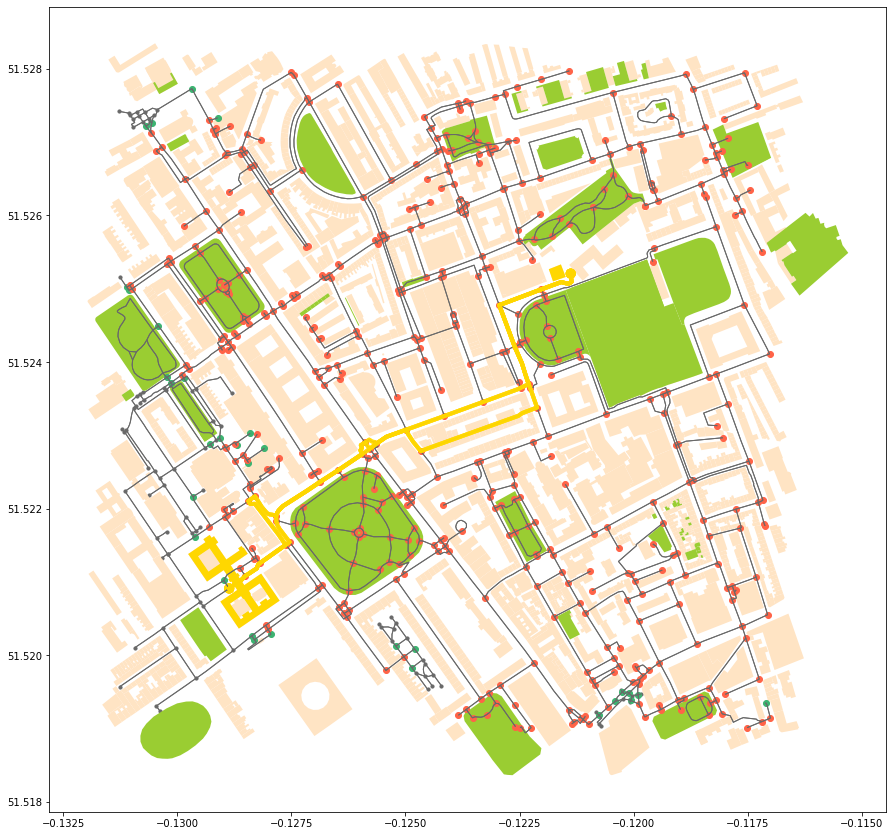



Dijkstra total iterations: 478
Route length: 835.7


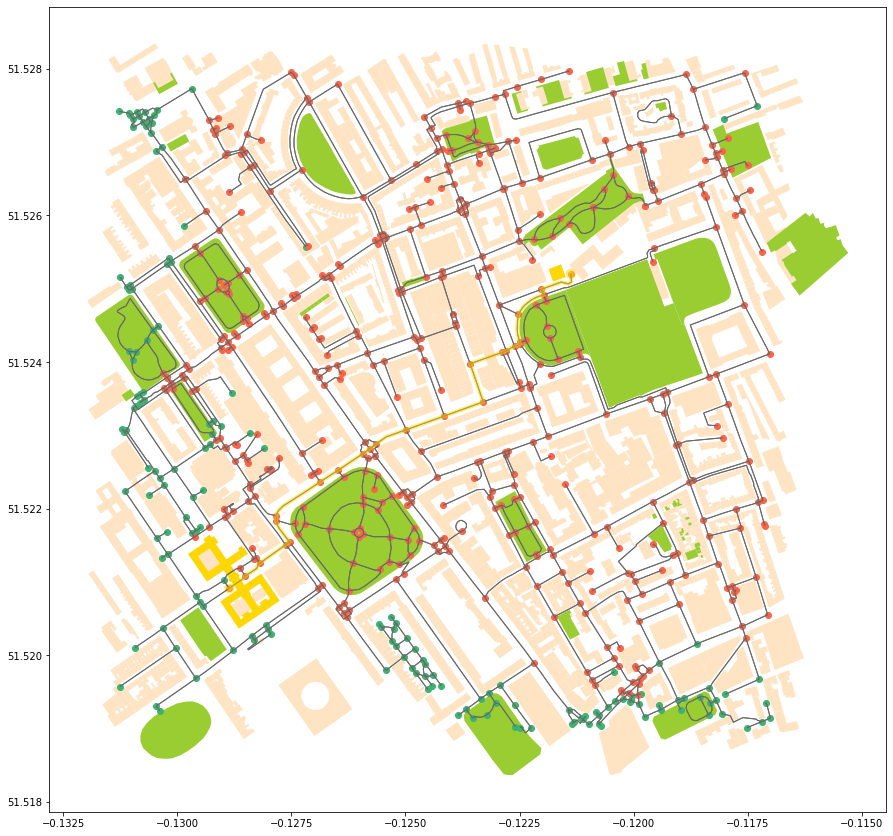



A_star total iterations: 58
Route length: 835.7


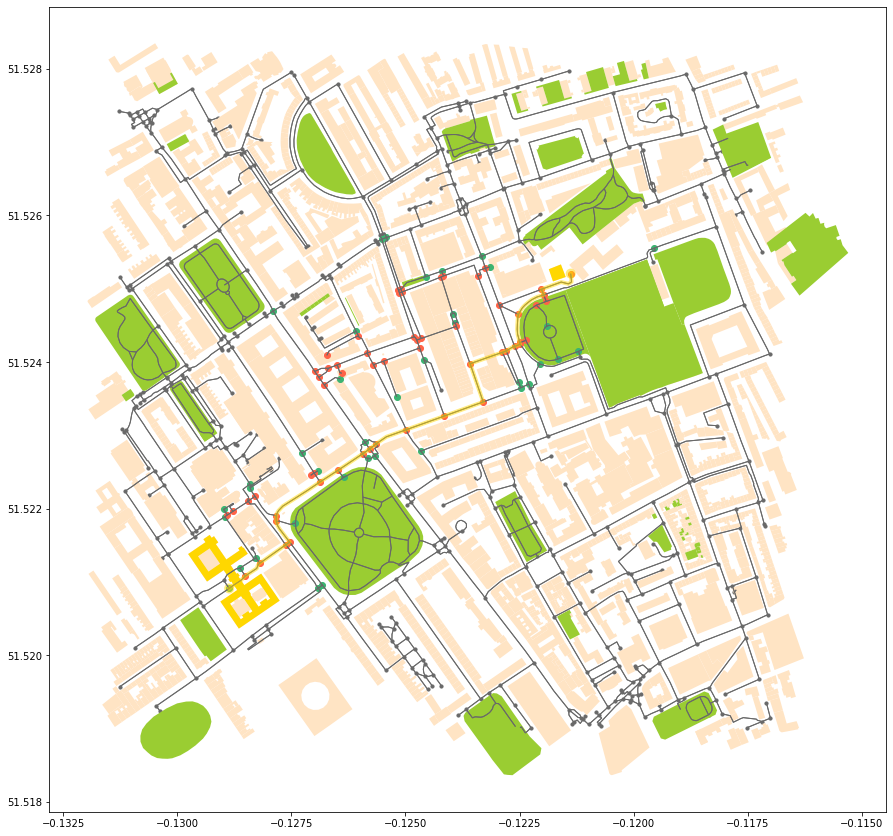



walk_in_the_park total iterations: 65
Route length: 1096.7740000000001


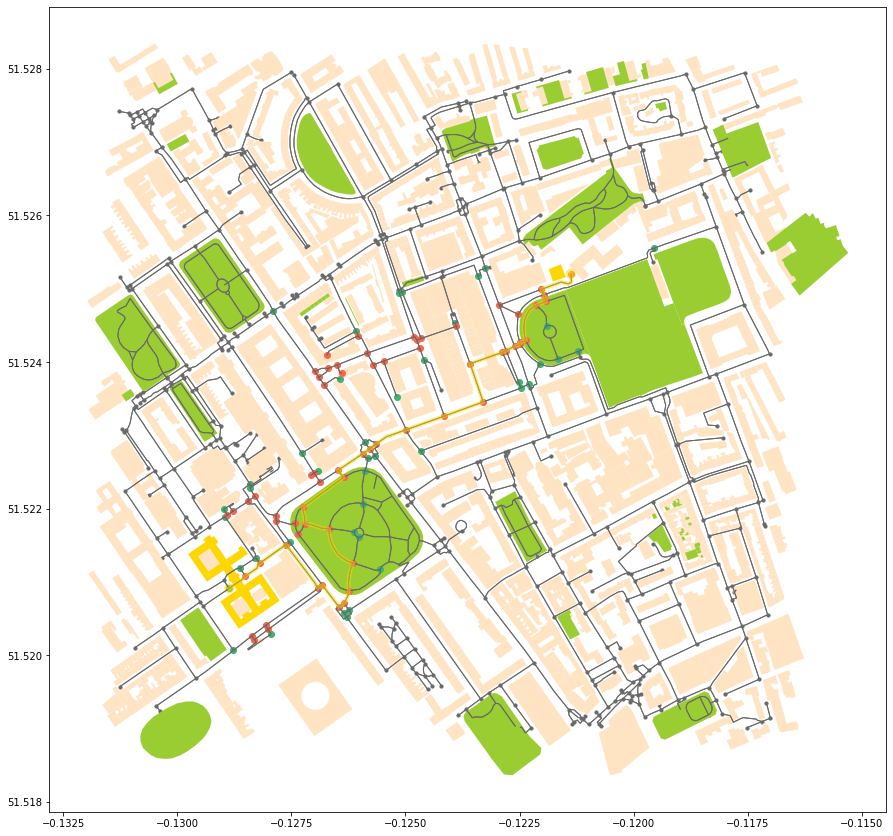

In [300]:
map_widget(51.523489534850285, -0.12405729178673333, 500, "Foundling Museum", "Senate House", 1000, True)

In [291]:
test = OSMLocation(51.523489534850285, -0.12405729178673333, 500)

/usr/local/lib/python3.7/dist-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/usr/local/lib/python3.7/dist-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


In [293]:
test.graph.edges

OutMultiEdgeView([(104302, 107844, 0), (104302, 881889759, 0), (104302, 108028, 0), (107835, 764867054, 0), (107835, 742854884, 0), (107835, 107863, 0), (107836, 764867047, 0), (107836, 764867054, 0), (107836, 1843345666, 0), (107837, 764867047, 0), (107839, 4360451852, 0), (107839, 2284375270, 0), (107839, 976973186, 0), (107843, 8998120956, 0), (107843, 4715890871, 0), (107843, 7050696569, 0), (107844, 4715890870, 0), (107844, 104302, 0), (107844, 4715890871, 0), (107855, 8481522224, 0), (107855, 1104496313, 0), (107855, 1104496316, 0), (107856, 5424828937, 0), (107856, 25472873, 0), (107856, 60728181, 0), (107856, 14728072, 0), (107857, 25475739, 0), (107857, 12689153, 0), (107857, 1156288959, 0), (107858, 13491061, 0), (107858, 1110129873, 0), (107858, 1110129865, 0), (107860, 11767207, 0), (107860, 11767208, 0), (107860, 25472875, 0), (107863, 107835, 0), (107863, 1104473062, 0), (107863, 11767206, 0), (107864, 4360460587, 0), (107864, 4360460588, 0), (107864, 4360469334, 0), (107

In [296]:
test.edges.loc[(104302, 107844, 0)]["in_park"]

False